In [43]:
import uproot	
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import awkward as ak
from scipy.optimize import curve_fit
from methods.fit_linear_regression_model import fit_linear_regression_model
import sklearn
%matplotlib inline

In [44]:
file = uproot.open(
    "tracking_losses_ntuple_B_default_radlength_endVelo.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1"
)

# selektiere nur elektronen von B->K*ee
allcolumns = file.arrays()
found = allcolumns[
    (allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromB)
]  # B: 9056
lost = allcolumns[
    (allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromB)
]  # B: 1466

electrons = allcolumns[(allcolumns.isElectron) & (allcolumns.fromB)]

print(ak.num(found, axis=0), ak.num(lost, axis=0))
print(ak.num(electrons, axis=0))
# ak.count(found, axis=None)

40402 10099
50501


In [45]:
rad_length_found = ak.to_numpy(found["rad_length_frac"])
eta_found = ak.to_numpy(found["eta"])
rad_length_lost = ak.to_numpy(lost["rad_length_frac"])
eta_lost = ak.to_numpy(lost["eta"])

stretch_factor = ak.num(eta_lost, axis=0) / ak.num(eta_found, axis=0)
print("stretch factor: ", stretch_factor)

stretch factor:  0.24996287312509283


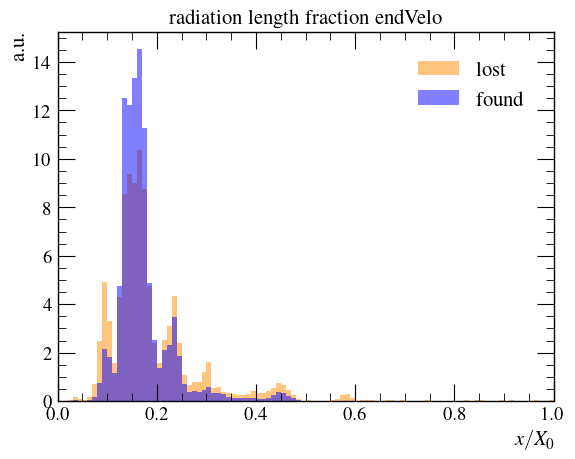

In [46]:
plt.hist(
    rad_length_lost,
    bins=100,
    density=True,
    alpha=0.5,
    color="darkorange",
    histtype="bar",
    label="lost",
    range=[0, 1],
)
plt.hist(
    rad_length_found,
    bins=100,
    density=True,
    alpha=0.5,
    color="blue",
    histtype="bar",
    label="found",
    range=[0, 1],
)
plt.xlim(0, 1)
# plt.yscale("log")
plt.title("radiation length fraction endVelo")
plt.xlabel(f"$x/X_0$")
plt.ylabel("a.u.")

plt.legend()
plt.show()

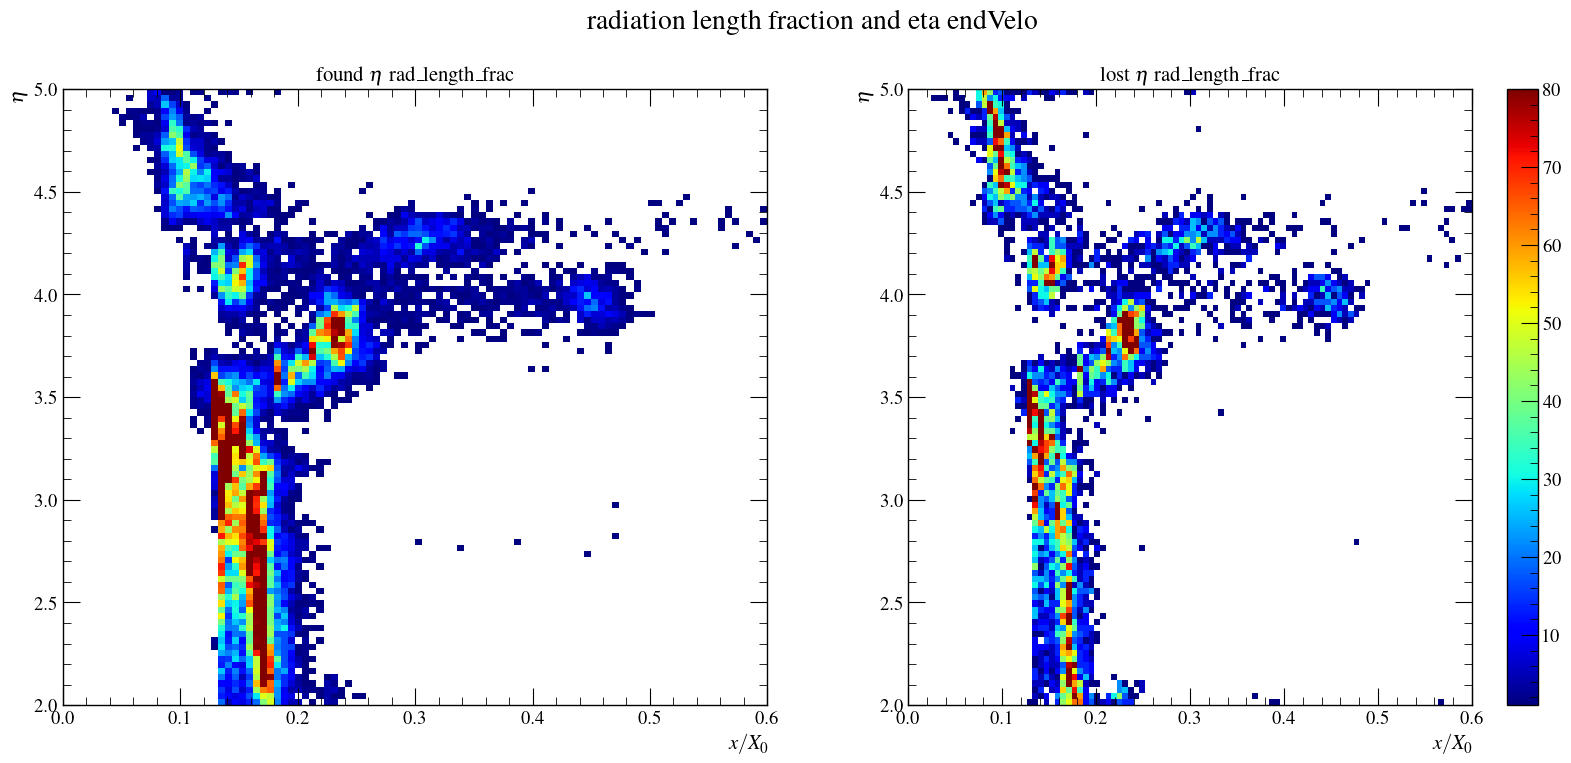

In [47]:
nbins = 100
vmax = 80

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

a0 = ax0.hist2d(
    rad_length_found,
    eta_found,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[0, 0.6], [2, 5]],
)
ax0.set_xlabel(f"$x/X_0$")
ax0.set_ylabel(f"$\eta$")
ax0.set_title(f"found $\eta$ rad_length_frac")

a1 = ax1.hist2d(
    rad_length_lost,
    eta_lost,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax * stretch_factor,
    range=[[0, 0.6], [2, 5]],
)
ax1.set_xlabel(f"$x/X_0$")
ax1.set_ylabel(f"$\eta$")
ax1.set_title(f"lost $\eta$ rad_length_frac")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.suptitle("radiation length fraction and eta endVelo")
plt.colorbar(a0[3], ax=ax1)

plt.show()

Parameterisation for rad_length_frac:
intercept= 0.0
coef= {'1': 0.19436659767031483, 'x': -0.0002934072350452474, 'y': -0.00011050606423805956, 'tx': 0.22076931190684765, 'ty': 0.07813480395105185, 'qop': -11.837351954632934, 'x^2': -2.0111718729828063e-06, 'x y': 9.09756297060689e-06, 'x tx': -0.0071441555126283435, 'x ty': 0.01601317688273909, 'x qop': 0.6215416537184049, 'y^2': -6.877429438893236e-06, 'y tx': -0.03246512737106646, 'y ty': 0.009236443466565325, 'y qop': -0.7656982001003853, 'tx^2': 3.2721253340872036, 'tx ty': 6.990115604991107, 'tx qop': -728.51712427984, 'ty^2': -4.166569974702085, 'ty qop': 587.2224646668662, 'qop^2': 6.145749766573158, 'x^3': -1.6562683153707752e-07, 'x^2 y': -1.2001632657575304e-06, 'x^2 tx': 0.00040230376049067056, 'x^2 ty': -0.0003226579491818191, 'x^2 qop': 0.002985359658961018, 'x y^2': -5.185010866064232e-07, 'x y tx': 0.0029804615695217043, 'x y ty': 0.0012164498083769432, 'x y qop': 0.0029776397974184527, 'x tx^2': -0.3154073863149152, '

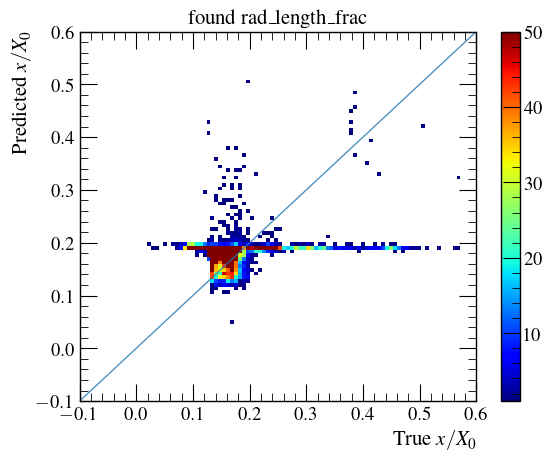

In [50]:
rad_length_frac = found["rad_length_frac"]
# @ z = 9400.mm or 770.mm
state = 1

if state == 1:
    slopex = found["ideal_state_770_tx"]
    slopey = found["ideal_state_770_ty"]
    x = found["ideal_state_770_x"]
    y = found["ideal_state_770_y"]
    qop = found["ideal_state_770_qop"]
elif state == 2:
    slopex = found["ideal_state_9410_tx"]
    slopey = found["ideal_state_9410_ty"]
    x = found["ideal_state_9410_x"]
    y = found["ideal_state_9410_y"]
    qop = found["ideal_state_9410_qop"]

data = ak.zip({
    "rad_length_frac": rad_length_frac,
    "x": x,
    "y": y,
    "tx": slopex,
    "ty": slopey,
    "qop": qop,
})
lin_reg, features, xx0_test, xx0_predicted = fit_linear_regression_model(
    data,
    "rad_length_frac",
    ["x", "y", "tx", "ty", "qop"],
    4,
    include_bias=True,
)

nbins = 100
vmax = 50

a0 = plt.hist2d(
    xx0_test,
    xx0_predicted,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax,
    range=[[-0.1, 0.6], [-0.1, 0.6]],
)
plt.plot([-0.1, 0.6], [-0.1, 0.6], marker="", alpha=0.8)
plt.xlabel(f"True $x/X_0$")
plt.ylabel(f"Predicted $x/X_0$")
plt.title(f"found rad_length_frac")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.colorbar(a0[3])
plt.show()

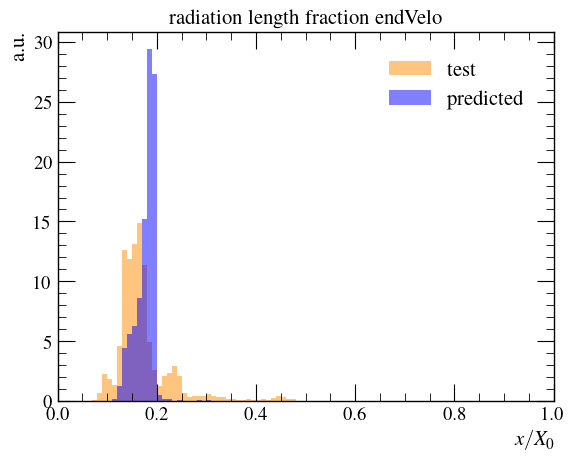

In [51]:
plt.hist(
    xx0_test,
    bins=100,
    density=True,
    alpha=0.5,
    color="darkorange",
    histtype="bar",
    label="test",
    range=[0, 1],
)
plt.hist(
    xx0_predicted,
    bins=100,
    density=True,
    alpha=0.5,
    color="blue",
    histtype="bar",
    label="predicted",
    range=[0, 1],
)
plt.xlim(0, 1)
# plt.yscale("log")
plt.title("radiation length fraction endVelo")
plt.xlabel(f"$x/X_0$")
plt.ylabel("a.u.")

plt.legend()
plt.show()

Parameterisation for rad_length_frac:
intercept= 0.0
coef= {'1': 0.24562140630345797, 'x': -0.0006147519300623754, 'y': 0.00013149294035773212, 'tx': 0.40993139584024857, 'ty': -0.17613130993997955, 'qop': -2.431621847221756, 'x^2': -2.537929422256502e-05, 'x y': 1.6503609236837168e-05, 'x tx': 0.014114349319941343, 'x ty': -0.015914217992780068, 'x qop': -0.3138750804691517, 'y^2': 8.004082295422125e-06, 'y tx': -0.0007103518977325451, 'y ty': -0.012102735170731998, 'y qop': -0.01613366131755978, 'tx^2': -1.1805199392607937, 'tx ty': 2.630285174738731, 'tx qop': 0.2259863956524285, 'ty^2': -0.9000770143303645, 'ty qop': 0.035317808178541486, 'qop^2': 0.506257028947111, 'x^3': -1.054613771280784e-06, 'x^2 y': -7.542919321773425e-07, 'x^2 tx': 0.0016046817739745617, 'x^2 ty': 0.0041420285105903745, 'x^2 qop': 0.021289920901612722, 'x y^2': 1.6630958165414549e-06, 'x y tx': -0.0029322410866066016, 'x y ty': 0.00026646565396820643, 'x y qop': 0.008117926325135527, 'x tx^2': -0.60079879050

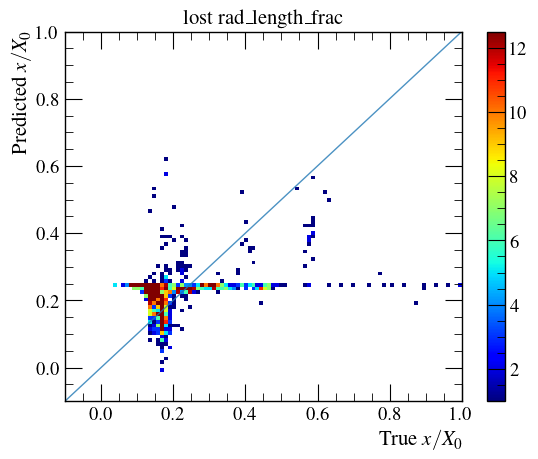

In [49]:
rad_length_frac = lost["rad_length_frac"]
# @ z = 9400.mm or 770.mm
state = 1

if state == 1:
    slopex = lost["ideal_state_770_tx"]
    slopey = lost["ideal_state_770_ty"]
    x = lost["ideal_state_770_x"]
    y = lost["ideal_state_770_y"]
    qop = lost["ideal_state_770_qop"]
elif state == 2:
    slopex = lost["ideal_state_9410_tx"]
    slopey = lost["ideal_state_9410_ty"]
    x = lost["ideal_state_9410_x"]
    y = lost["ideal_state_9410_y"]
    qop = lost["ideal_state_9410_qop"]

data = ak.zip(
    {
        "rad_length_frac": rad_length_frac,
        "x": x,
        "y": y,
        "tx": slopex,
        "ty": slopey,
        "qop": qop,
    }
)
lin_reg, features, xx0_test, xx0_predicted = fit_linear_regression_model(
    data,
    "rad_length_frac",
    ["x", "y", "tx", "ty", "qop"],
    5,
    include_bias=True,
)

nbins = 100
vmax = 50

a0 = plt.hist2d(
    xx0_test,
    xx0_predicted,
    density=False,
    bins=nbins,
    cmap=plt.cm.jet,
    cmin=1,
    vmax=vmax * stretch_factor,
    range=[[-0.1, 1.0], [-0.1, 1.0]],
)
plt.plot([-0.1, 1.0], [-0.1, 1.0], marker="", alpha=0.8)
plt.xlabel(f"True $x/X_0$")
plt.ylabel(f"Predicted $x/X_0$")
plt.title(f"lost rad_length_frac")
# ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.colorbar(a0[3])
plt.show()

In [58]:
endT_x = lost[np.isnan(lost.ideal_state_9410_x)]["ideal_state_9410_x"]
endT_x

<Array [nan, nan, nan, nan, nan, nan, nan, nan, nan] type='9 * float64'>